In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.fftpack import dct, idct
from PIL import Image
from matrepr import mdisplay, mprint, to_html

In [2]:
def crop_img(img, size):
    w, h = img.size
    left = (w - size) // 2
    top = (h - size) // 2
    right = (w + size) // 2
    bottom = (h + size) // 2
    return img.crop((left, top, right, bottom))

# Standard JPEG quantization table for luminance (brightness) in an 8x8 block
jpeg_quant_table = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

# apply DCT for the whole image
def block_dct(image, block_size=8):
    h, w = image.shape
    dct_image = np.zeros((w, h))
    reconstructed_img = np.zeros((w, h))
    for row in range(0, h, block_size):
        for col in range(0, w, block_size):
            block = image[row:row + block_size, col:col + block_size]
            shifted_block = block - 128
            dct_block = dct(dct(shifted_block.T, norm='ortho').T, norm='ortho')
            quantized_dct_block = np.round(dct_block / jpeg_quant_table)
            dct_image[row:row + block_size, col:col + block_size] = quantized_dct_block
            
            dequantized_dct_block = quantized_dct_block * jpeg_quant_table
            reconstructed_block = idct(idct(dequantized_dct_block.T, norm='ortho').T, norm='ortho')
            reconstructed_block += 128
            reconstructed_img[row:row + block_size, col:col + block_size] = reconstructed_block
    return reconstructed_img, dct_image

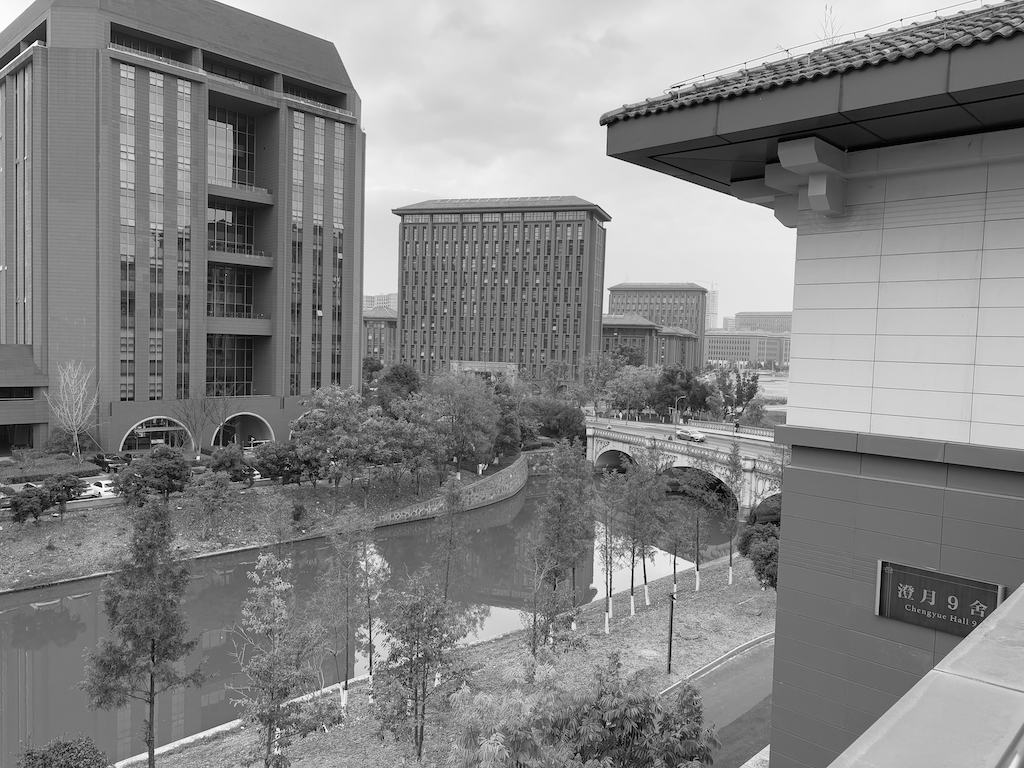

In [3]:
IMG_DIR = 'data'
img = Image.open(os.path.join(IMG_DIR, 'uni-1024.png')).convert('L')
img

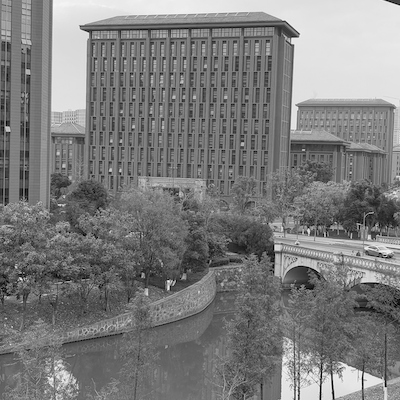

In [4]:
cropped = crop_img(img, 400)
cropped

In [12]:
block_size = 8
np.random.seed(777)  # For reproducibility
if img:
    w, h = img.size
    rng = np.random.default_rng()
    cx, cy = rng.integers(0, min(w, h) - block_size, 2)
    image_block = np.array(img, dtype=np.float64)[cx:cx + block_size, cy:cy + block_size]
else:
    # Generate an 8x8 block of an example image (e.g., smooth gradient with some noise)
    image_block = np.linspace(0, 255, block_size ** 2).reshape(block_size, block_size)
    image_block = image_block + np.random.normal(scale=10, size=(block_size, block_size)) # Add noise

In [13]:
shifted_block = image_block - 128
shifted_block

array([[-32., -27., -25., -26., -22., -23., -23., -21.],
       [ -5.,  -3.,  -7.,  -1.,  -2.,  -5.,  -3.,  -1.],
       [-54.,  -8.,  -5., -33.,   1.,  -6.,   2., -36.],
       [-65., -11.,  -5., -42.,   2.,  -8.,   1., -41.],
       [-57.,  -4.,  -7., -37.,   2.,  -5.,  -1., -38.],
       [ 26.,   1., -11., -35.,   3.,  -5.,   3., -50.],
       [ 36.,  -1., -12., -31.,   5.,  -4.,   6., -48.],
       [ 14.,  -8., -11., -32.,   3.,  -5.,   4., -48.]])

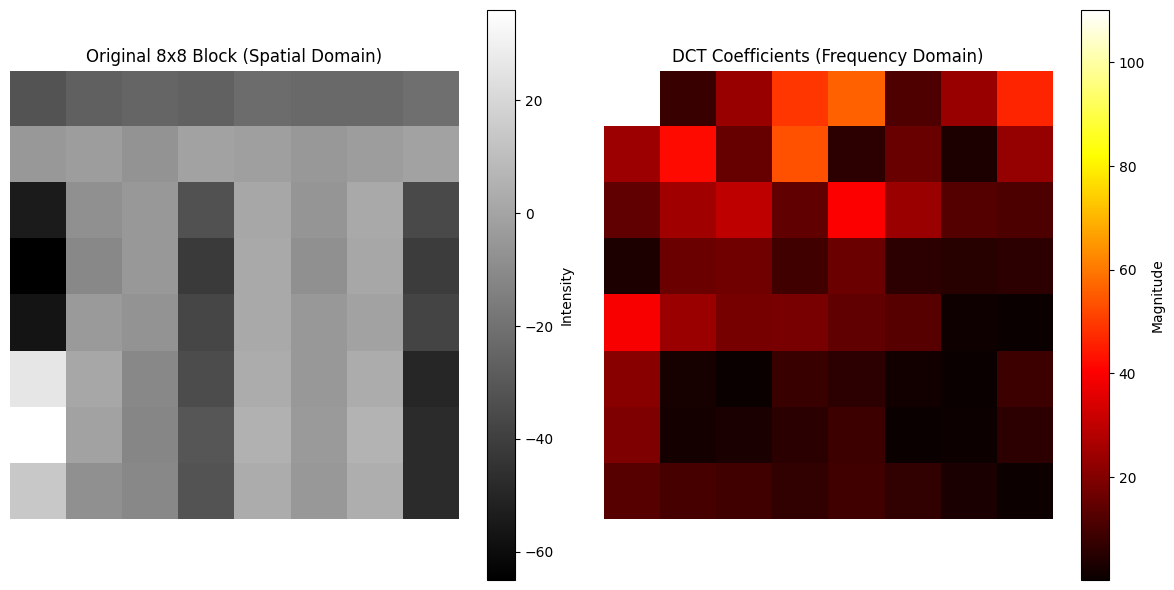

In [14]:
# Apply 2D DCT to the block
dct_block = dct(dct(shifted_block.T, norm='ortho').T, norm='ortho')

# Visualize the original block and its DCT coefficients
plt.figure(figsize=(12, 6))

# Original block
plt.subplot(1, 2, 1)
plt.imshow(shifted_block, cmap='gray', extent=[0, block_size, block_size, 0])
plt.title("Original 8x8 Block (Spatial Domain)")
plt.colorbar(label="Intensity")
plt.axis("off")

# DCT coefficients (showing energy concentration)
plt.subplot(1, 2, 2)
plt.imshow(np.abs(dct_block), cmap='hot', extent=[0, block_size, block_size, 0])
plt.title("DCT Coefficients (Frequency Domain)")
plt.colorbar(label="Magnitude")
plt.axis("off")

plt.tight_layout()
plt.show()

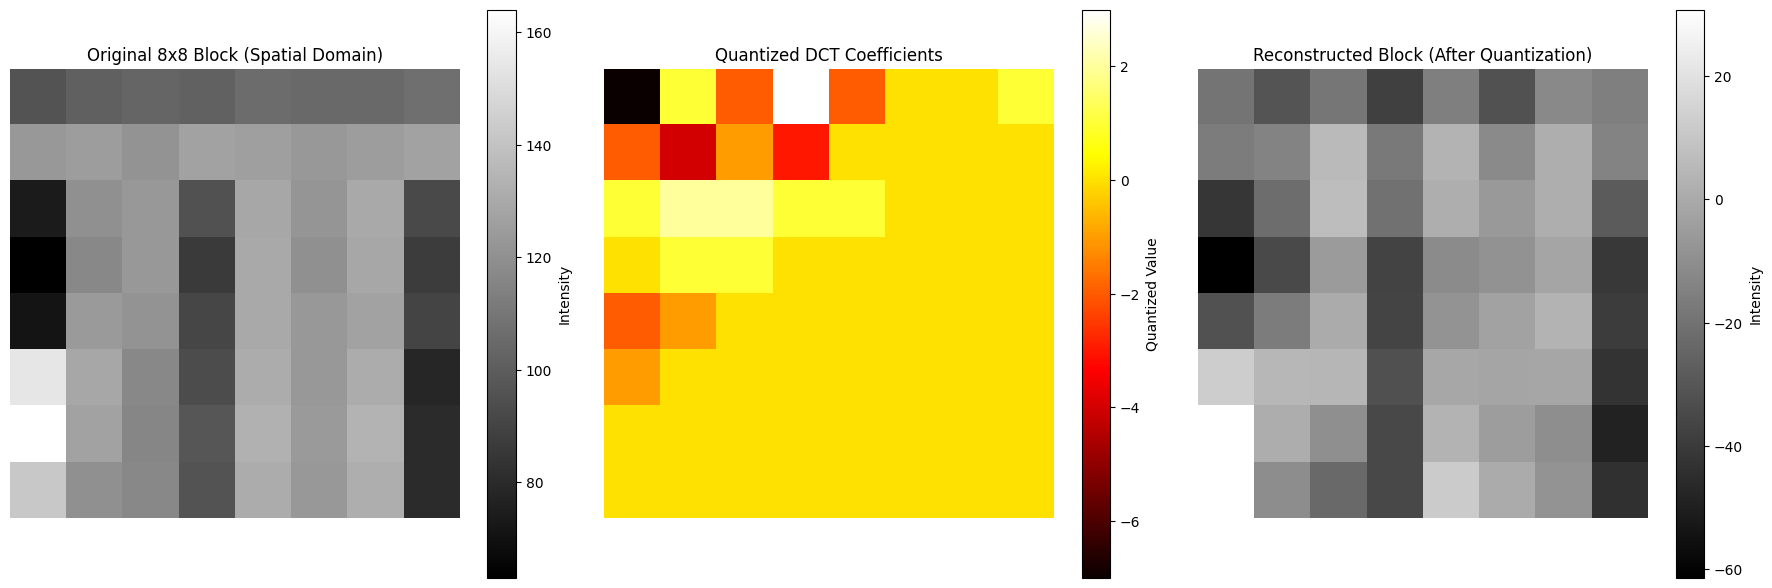

In [ ]:
# Quantize the DCT coefficients by dividing by the quantization table and rounding
quantized_dct_block = np.round(dct_block / jpeg_quant_table)
# Reconstruct the block from the quantized DCT coefficients (for comparison)
dequantized_dct_block = quantized_dct_block * jpeg_quant_table
reconstructed_block = idct(idct(dequantized_dct_block.T, norm='ortho').T, norm='ortho')

# Visualize original block, quantized DCT coefficients, and reconstructed block
plt.figure(figsize=(18, 6))

# Original block
plt.subplot(1, 2, 1)
plt.imshow(image_block, cmap='gray', extent=[0, block_size, block_size, 0])
plt.title("Original 8x8 Block (Spatial Domain)")
plt.colorbar(label="Intensity")
plt.axis("off")

# Reconstructed block from quantized coefficients
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_block, cmap='gray', extent=[0, block_size, block_size, 0])
plt.title("Reconstructed Block (After Quantization)")
plt.colorbar(label="Intensity")
plt.axis("off")

plt.tight_layout()
plt.show()

(np.float64(0.0), np.float64(8.0), np.float64(8.0), np.float64(0.0))

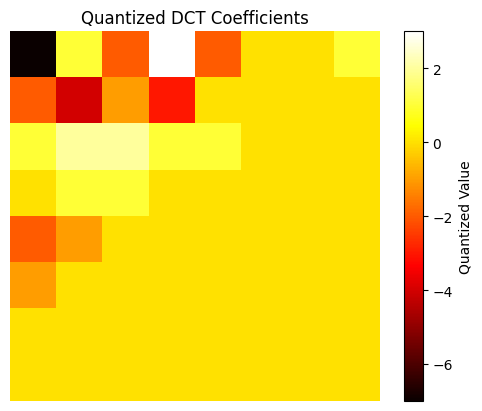

In [24]:
# Quantized DCT coefficients (with many zeros)
# plt.subplot(1, 3, 2)
plt.imshow(quantized_dct_block, cmap='hot', extent=[0, block_size, block_size, 0])
plt.title("Quantized DCT Coefficients")
plt.colorbar(label="Quantized Value")
plt.axis("off")

In [23]:
html_table = to_html(quantized_dct_block)
with open('table.html', 'w') as f:
    f.write(html_table)
mdisplay(quantized_dct_block)

,0,1,2,3,4,5,6,7
0,-7,1,-2,3,-2,-0,-0,1
1,-2,-4,-1,-3,0,-0,0,-0
2,1,2,2,1,1,0,0,-0
3,-0,1,1,0,0,0,0,-0
4,-2,-1,-0,-0,-0,-0,-0,0
5,-1,0,-0,0,-0,0,-0,0
6,-0,0,-0,0,-0,-0,-0,0
7,-0,-0,-0,-0,-0,-0,-0,-0


In [61]:
decompressed, _ = block_dct(np.array(cropped, dtype=np.float64), block_size)
decompressed = np.clip(decompressed, 0, 255).astype(np.uint8)

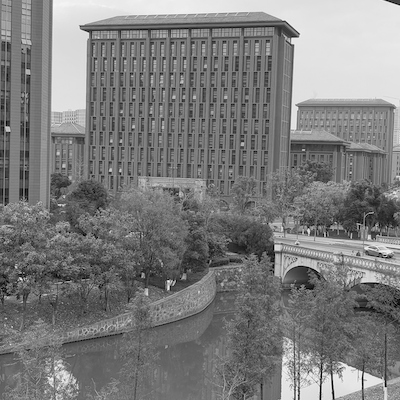

In [64]:
cropped

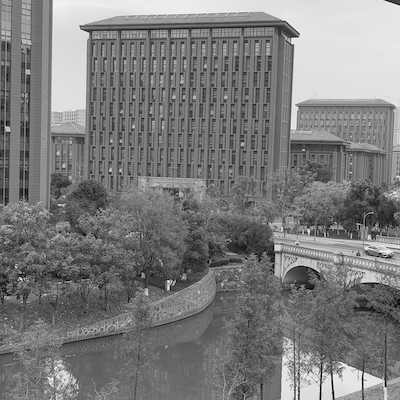

In [65]:
Image.fromarray(decompressed)

In [66]:
diff = np.abs(np.array(cropped, dtype=np.float64) - decompressed)
normdiff = (diff - np.min(diff)) / (np.max(diff) - np.min(diff))
normdiff = (255 * normdiff).astype(np.uint8)

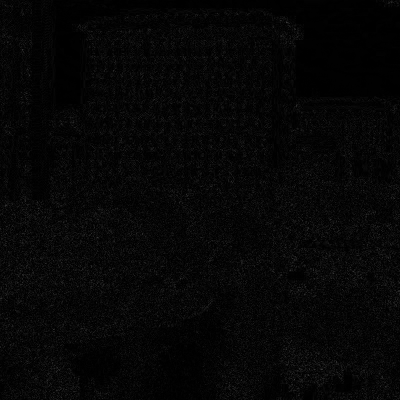

In [70]:
Image.fromarray(diff.astype(np.uint8))

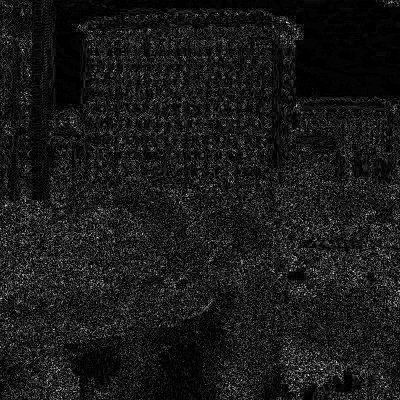

In [73]:
Image.fromarray(normdiff)